In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from importlib import reload
from tqdm import tqdm

from sklearn.decomposition import PCA

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry, haversine, calc_segment_count
import feature_extraction as fe
from sklearn.ensemble import RandomForestClassifier

import sqlite3

from analysis_image import AnalysisImage
from keras.preprocessing import image

c:\Users\Juanes\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import eloisa
reload(eloisa)
from eloisa import Eloisa

In [3]:
ee.Authenticate()
ee.Initialize()

In [4]:
tegu_200_eloisa = None

In [4]:
# Load eloisa_databases/tegu_200x200_flatten.pkl
with open('eloisa_databases/tegu_200x200_flatten.pkl', 'rb') as f:
    tegu_200_eloisa = pickle.load(f)

tegu_200_eloisa._database = sqlite3.connect(tegu_200_eloisa.db_path)

In [5]:
from tensorflow.keras.applications import ResNet152V2 as resnet
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_p

In [6]:
SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
# FEATURES = ['B2', 'B3', 'B4']
years = [2018, 2019, 2020, 2021, 2022, 2023]

In [ ]:
subspace_cluster = tegu_200_eloisa.subspace_clustering(years=years, model=resnet, algorithm="spams", n_clusters=50, sample_fraction=0.05)

In [26]:
# Save subspace_cluster as pickle file
with open('subspace_cluster.pkl', 'wb') as f:
    pickle.dump(subspace_cluster, f)

In [7]:
# Open subspace_cluster.pkl
with open('subspace_cluster_10.pkl', 'rb') as f:
    subspace_cluster = pickle.load(f)

In [8]:
sampled_labels = subspace_cluster.labels_

In [9]:
# Collect data from all specified years
data_list = [tegu_200_eloisa._data[year][resnet.__name__ + "_reduced"] for year in years]
concatenated_data = pd.concat(data_list, axis=0)

# Sample a subset of the data
sampled_data = concatenated_data.sample(frac=0.1, random_state=tegu_200_eloisa._seed)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
# Split the sampled_data and sampled_labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sampled_data, sampled_labels, test_size=0.2, random_state=tegu_200_eloisa._seed)

In [21]:
# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=500, random_state=tegu_200_eloisa._seed)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=2024)

In [22]:
y_pred = clf.predict(X_test)

In [23]:
accuracy_score(y_test, y_pred)

0.28365384615384615

In [ ]:
# Train a classifier on the sampled data to predict cluster labels
classifier = RandomForestClassifier(random_state=tegu_200_eloisa._seed)
classifier.fit(sampled_data, sampled_labels)

# Predict cluster labels for the entire dataset
cluster_labels = classifier.predict(concatenated_data)

In [12]:
# Train an xgboost classifier
import xgboost as xgb
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, CheckpointSaver
from skopt import load
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import accuracy_score
from skopt.plots import plot_objective, plot_histogram


In [46]:
# Split the sampled_data and sampled_labels into training and testing sets
X_full, X_test, y_full, y_test = train_test_split(sampled_data, sampled_labels, test_size=0.2, random_state=tegu_200_eloisa._seed)

# Create validation set from the training set
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.25, random_state=tegu_200_eloisa._seed)

xgb_clf = XGBClassifier(random_state=tegu_200_eloisa._seed, 
                        early_stopping_rounds=10, 
                        eval_metric='mlogloss',
                        device='cuda')

# Define the search space
search_spaces = {
    'n_estimators': Integer(750, 1500),  
    'learning_rate': Real(0.005, 0.1, 'log-uniform'),  
    'max_depth': Integer(1, 10),  
    'subsample': Real(0.5, 1.0, 'uniform'),  
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),  
    # 'reg_alpha': Real(0.01, 1.0, 'log-uniform'),  
    # 'reg_lambda': Real(0.01, 1.0, 'log-uniform')  
}

# Set up the BayesSearchCV object
opt = BayesSearchCV(estimator=xgb_clf, 
                    search_spaces=search_spaces, 
                    n_iter=100,
                    cv=5, 
                    n_jobs=-1, 
                    random_state=tegu_200_eloisa._seed)

deadline = DeadlineStopper(total_time=60*60*2) # 18 hours

checkpoint_saver = CheckpointSaver("xgb_optimization_checkpoint.pkl")

In [47]:
# Fit the BayesSearchCV object
opt.fit(X_train, y_train, 
        callback=[deadline, checkpoint_saver], 
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=True)

[0]	validation_0-mlogloss:3.88884	validation_1-mlogloss:3.90234
[1]	validation_0-mlogloss:3.86794	validation_1-mlogloss:3.89423
[2]	validation_0-mlogloss:3.84698	validation_1-mlogloss:3.88653
[3]	validation_0-mlogloss:3.82498	validation_1-mlogloss:3.87976
[4]	validation_0-mlogloss:3.80204	validation_1-mlogloss:3.86990
[5]	validation_0-mlogloss:3.77939	validation_1-mlogloss:3.86037
[6]	validation_0-mlogloss:3.75756	validation_1-mlogloss:3.85365
[7]	validation_0-mlogloss:3.73665	validation_1-mlogloss:3.84547
[8]	validation_0-mlogloss:3.71532	validation_1-mlogloss:3.83967
[9]	validation_0-mlogloss:3.69368	validation_1-mlogloss:3.83235
[10]	validation_0-mlogloss:3.67292	validation_1-mlogloss:3.82462
[11]	validation_0-mlogloss:3.65191	validation_1-mlogloss:3.81743
[12]	validation_0-mlogloss:3.62983	validation_1-mlogloss:3.80854
[13]	validation_0-mlogloss:3.60854	validation_1-mlogloss:3.80138
[14]	validation_0-mlogloss:3.58802	validation_1-mlogloss:3.79442
[15]	validation_0-mlogloss:3.56796	

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device='cuda',
                                      early_stopping_rounds=10,
                                      enable_categorical=False,
                                      eval_metric='mlogloss',
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rat...
              search_spaces={'colsample_bytree': Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.005, high=0.1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=750, high=1500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [48]:
# Get the best parameters
print(f"Best parameters: {opt.best_params_}")
print(f"Best score: {opt.best_score_}")

Best parameters: OrderedDict({'colsample_bytree': 0.7873872795747563, 'learning_rate': 0.006369250837050707, 'max_depth': 5, 'n_estimators': 1496, 'subsample': 0.7566072759319056})
Best score: 0.3597686746987952


In [49]:
y_pred = opt.best_estimator_.predict(X_test)

accuracy_score(y_test, y_pred)

0.41346153846153844

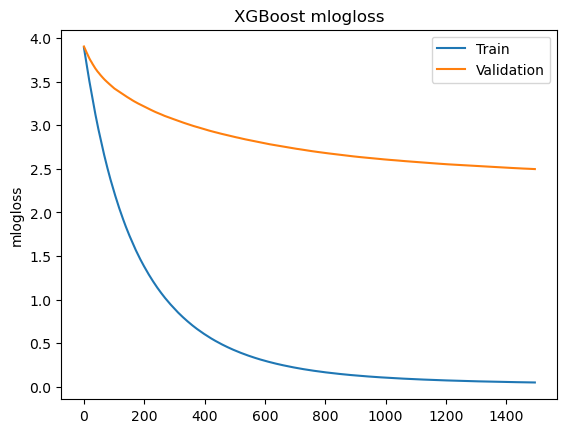

In [50]:
# Plot xgboost optimization results
results = opt.best_estimator_.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()


In [54]:
# save opt to pickle file
with open('xgb_opt.pkl', 'wb') as f:
    pickle.dump(opt, f)

In [51]:
opt.optimizer_results_[0]

          fun: -0.3597686746987952
            x: [0.7873872795747563, 0.006369250837050707, 5, 1496, 0.7566072759319056]
    func_vals: [-3.598e-01]
      x_iters: [[0.7873872795747563, 0.006369250837050707, 5, 1496, 0.7566072759319056]]
       models: []
        space: Space([Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                      Real(low=0.005, high=0.1, prior='log-uniform', transform='normalize'),
                      Integer(low=1, high=10, prior='uniform', transform='normalize'),
                      Integer(low=750, high=1500, prior='uniform', transform='normalize'),
                      Real(low=0.5, high=1.0, prior='uniform', transform='normalize')])
 random_state: RandomState(MT19937)
        specs:     args:              dimensions: [Real(low=0.5, high=1.0, prior='uniform', transform='normalize'), Real(low=0.005, high=0.1, prior='log-uniform', transform='normalize'), Integer(low=1, high=10, prior='uniform', transform='normalize'), Integer(l

IndexError: list index out of range

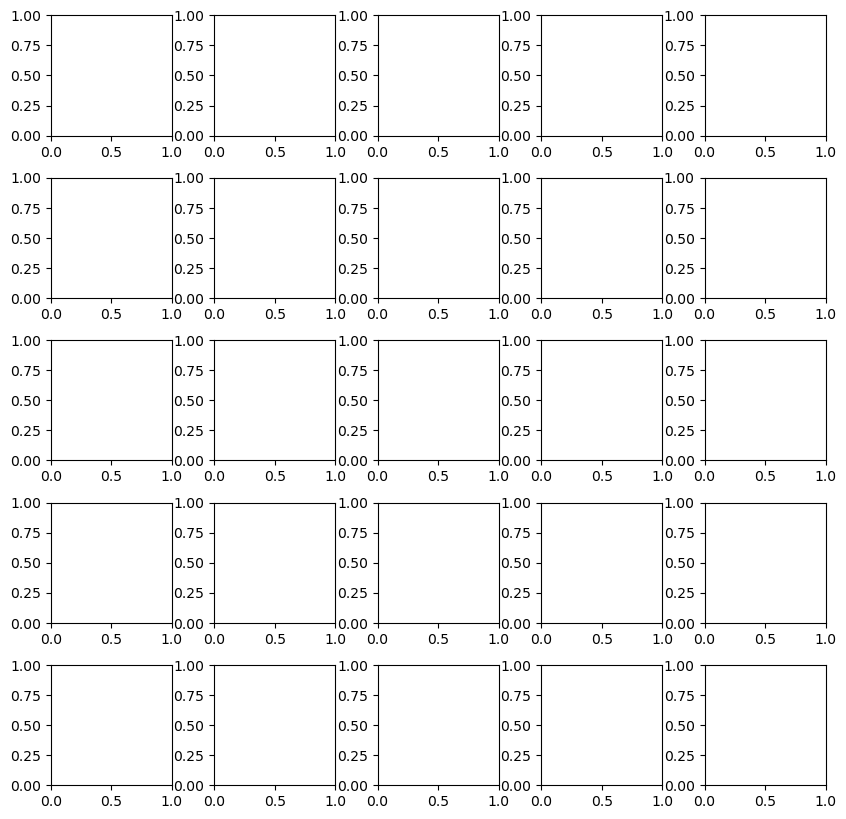

In [53]:
# Plot the BayesSearchCV results
_ = plot_objective(opt.optimizer_results_[0])

plt.show()


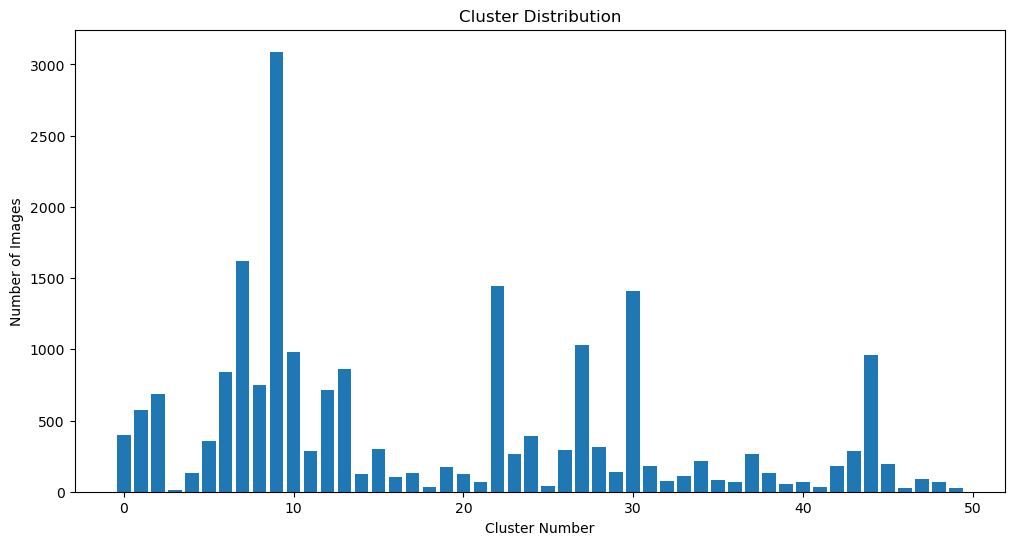

In [9]:
tegu_200_eloisa.plot_cluster_counts(years=years, model=resnet)

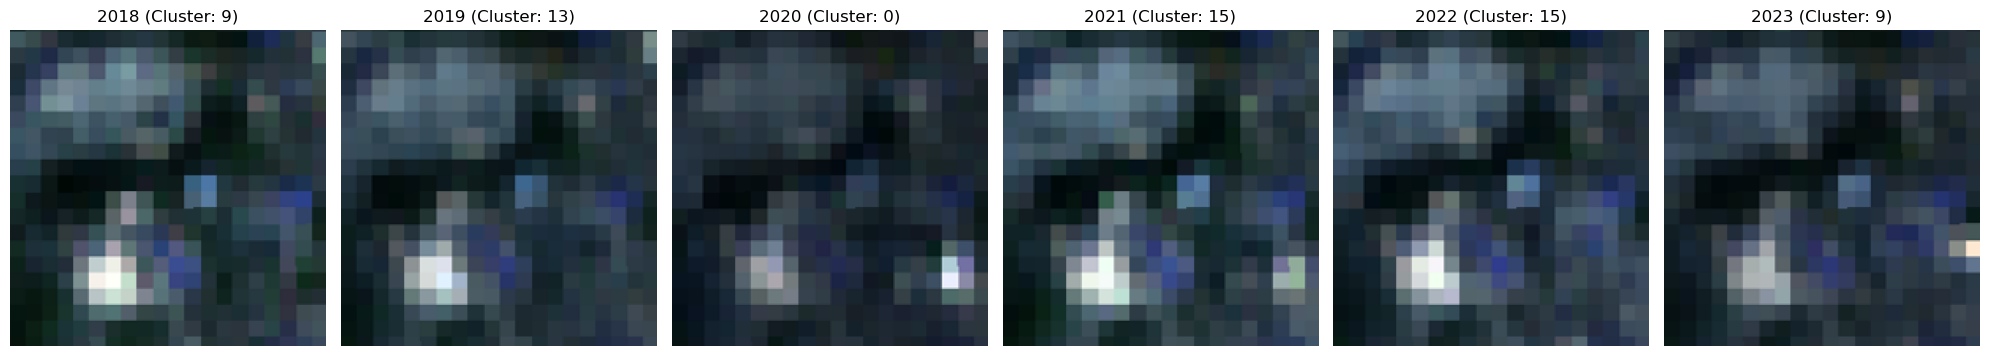

In [14]:
tegu_200_eloisa.show_clip_by_year(years=years, index=500, model=resnet)

In [11]:
import cluster_tester
reload(cluster_tester)
from cluster_tester import ClusterTester

In [16]:
tegucigalpa_image = AnalysisImage(presets='Tegucigalpa', year=2023, feature_bands=FEATURES)

img_height = haversine(coords=tegucigalpa_image.get_bounds(side='ceiling'))
img_width = haversine(coords=tegucigalpa_image.get_bounds(side='left'))

x_num_parts, y_num_parts = calc_segment_count(img_height, img_width, 200, 200)

subgeometries = split_geometry(tegucigalpa_image.geometry_sd, x_num_parts=x_num_parts, y_num_parts=y_num_parts)

In [17]:
precario_path = os.path.join("data", "tegucigalpa_PC.zip")
precario_gdf = gpd.read_file(precario_path)

In [18]:
cluster_location_info = tegu_200_eloisa.get_cluster_location_info(year=2023, model=resnet, subgeometries=subgeometries, dissolve_by_cluster=True)

In [19]:
tegu_cluster_tester = ClusterTester(cluster_location_info=cluster_location_info, 
                                    analysis_image=tegucigalpa_image, 
                                    validation_data=precario_gdf, 
                                    cluster_order=None, 
                                    num_clusters=75,
                                    palette='jet')

In [25]:
tegu_200_eloisa._database = ""
with open('eloisa_databases/tegu_200x200_flatten.pkl', 'wb') as f:
    pickle.dump(tegu_200_eloisa, f)
tegu_200_eloisa._database = sqlite3.connect(tegu_200_eloisa.db_path)

In [20]:
tegu_cluster_tester.plot_clusters() #TODO: FIX COLORING. Doesn't appear to be working correctly

Map(center=[14.0763396, -87.20787405], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

In [21]:
points = tegu_cluster_tester.create_sampling_points(n_points=5000)
cluster_metrics = tegu_cluster_tester.calc_sampling_metrics()

In [24]:
grouped_metrics = tegu_cluster_tester.group_clusters_and_calc_metrics(precision_min=0.1)

100%|██████████| 6884/6884 [16:15<00:00,  7.06it/s]


In [ ]:
grouped_metrics.sort_values(by='F1', ascending=False).head()

In [ ]:
tegu_cluster_tester.plot_top_cluster_combos(metric='F1', n_combos=1)